In [74]:
import re
import math
from functools import partial

In [75]:
import pandas as pd

In [81]:
df = pd.read_csv('../archive/laptops.csv', encoding='latin-1')

#drop the useless columns

df = df.drop(columns='Unnamed: 0')


In [82]:
def extract_product(product):
    product_list = product.split()
    product = product_list[0]
    if product_list[1].isalpha() or product_list[1][0].isalpha() :
        product += ' ' + product_list[1]
    return product

def extract_pure_resolution(screen_resolution):
    return re.search('[0-9]{3,4}x[0-9]{3,4}', screen_resolution).group()


In [83]:
df['Convertible'] = df['TypeName'] == '2 in 1 Convertible'
df['Product'] = df['Product'].apply(extract_product)
df['Retina Display'] = df['ScreenResolution'].str.contains('Retina Display')
df['Touchscreen'] = df['ScreenResolution'].str.contains("Touchscreen")
df['IPS Panel'] = df['ScreenResolution'].str.contains('IPS Panel')
df['Quad HD+'] = df['ScreenResolution'].str.contains('Quad HD+')
df['Ultra HD'] = df['ScreenResolution'].str.contains('Ultra HD')
df['ScreenResolution'] = df['ScreenResolution'].apply(extract_pure_resolution)

In [84]:
df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price_euros', 'Convertible',
       'Retina Display', 'Touchscreen', 'IPS Panel', 'Quad HD+', 'Ultra HD'],
      dtype='object')

In [85]:
df['CPU brand'] = df['Cpu'].apply(lambda x: x.split()[0])
df['Cpu speed'] = df['Cpu'].apply(lambda x: float(re.search('([0-9]{1,2}\.[0-9]{1,3}GHz)|([0-9]GHz)', x)[0].replace('GHz', '')))
df['free OpSys'] = df['OpSys'].apply(lambda x: x in ('Linux', 'Android', 'No OS'))
df['GPU_provider'] = df['Gpu'].apply(lambda x: x.split()[0])

In [86]:
df['Ram'] = df['Ram'].apply(lambda x: int(x.replace('GB', '')))
df['Weight'] = df['Weight'].apply(lambda x: float(x.replace('kg', '')))

In [87]:
cpu_types = {'Core M': 'Intel Core M',
 'Atom': 'Intel Atom',
 'Celeron': 'Intel Celeron',
 'Pentium': 'Intel Pentium',
 'i3': 'Intel i3',
 'i5': 'Intel i5',
 'i7': 'Intel i7',
 'Xeon': 'Intel Xeon',
 'AMD E-Series': 'AMD E',
 'AMD FX': 'AMD FX',
 'AMD A4': 'AMD A4',
 'AMD A6': 'AMD A6',
 'AMD A8': 'AMD A8',
 'AMD A9': 'AMD A9',
 'AMD A10': 'AMD A10',
 'AMD A12': 'AMD A12',
 'AMD Ryzen': 'AMD Ryzen',
 'Samsung': 'Samsung'}


In [88]:
for name, value in cpu_types.items():
    df.loc[df['Cpu'].str.contains(name),'Cpu']=value


In [89]:
df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price_euros', 'Convertible',
       'Retina Display', 'Touchscreen', 'IPS Panel', 'Quad HD+', 'Ultra HD',
       'CPU brand', 'Cpu speed', 'free OpSys', 'GPU_provider'],
      dtype='object')

In [90]:
df.drop(columns=['Gpu'], inplace=True)

In [91]:
optinal_features = ['Inches', 'ScreenResolution', 'Product']

In [92]:
memory_types = ('SSD', 'HDD', 'Flash Storage', 'Hybrid')

In [93]:
df['Memory'] = df['Memory'].apply(lambda x: x.replace('.0', ''))

def process_memory(memory, _type):
    gb_match = re.match('([0-9]{1,4})GB ' + _type, memory)
    if gb_match:
        return int(gb_match.groups()[0])
    
    tb_match = re.match('([0-9]{1,4})TB ' + _type, memory)

    if tb_match:
        return int(tb_match.groups()[0]) * 1000

    return 0


def process_combined_memory(_type, memory):
    split_memory = memory.split(' +  ')
    res = sum(process_memory(mem, _type) for mem in split_memory)
    return res

for memory_type in memory_types:
    df[memory_type] = df['Memory'].apply(partial(process_combined_memory, memory_type))


In [94]:

def resolution_to_number(resolution, diagonal):
    width, height = map(int, resolution.split('x'))
    return math.sqrt(width**2+height**2)/diagonal

In [95]:
df['Pixels Per Inch'] = df.apply(lambda x: resolution_to_number(x.ScreenResolution, x.Inches), axis=1)

In [96]:
df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'OpSys', 'Weight', 'Price_euros', 'Convertible',
       'Retina Display', 'Touchscreen', 'IPS Panel', 'Quad HD+', 'Ultra HD',
       'CPU brand', 'Cpu speed', 'free OpSys', 'GPU_provider', 'SSD', 'HDD',
       'Flash Storage', 'Hybrid', 'Pixels Per Inch'],
      dtype='object')

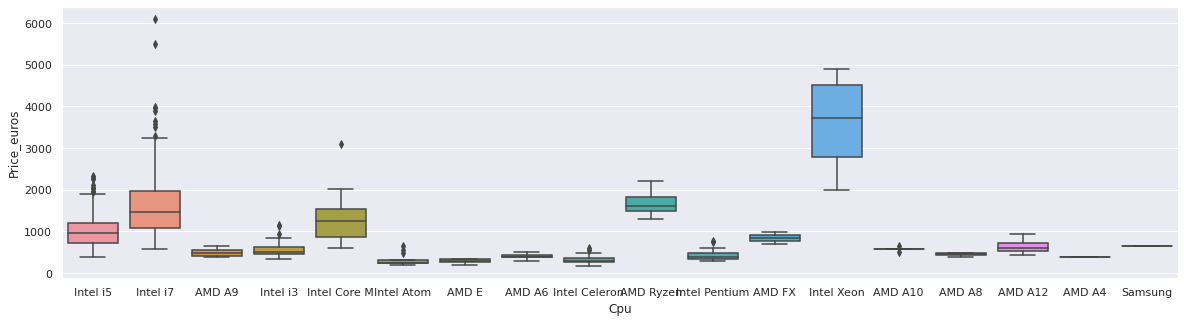

In [97]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(20,5)})

sns.boxplot(x=df["Cpu"], y=df["Price_euros"])
y=df["Price_euros"]

<AxesSubplot:xlabel='SSD', ylabel='Price_euros'>

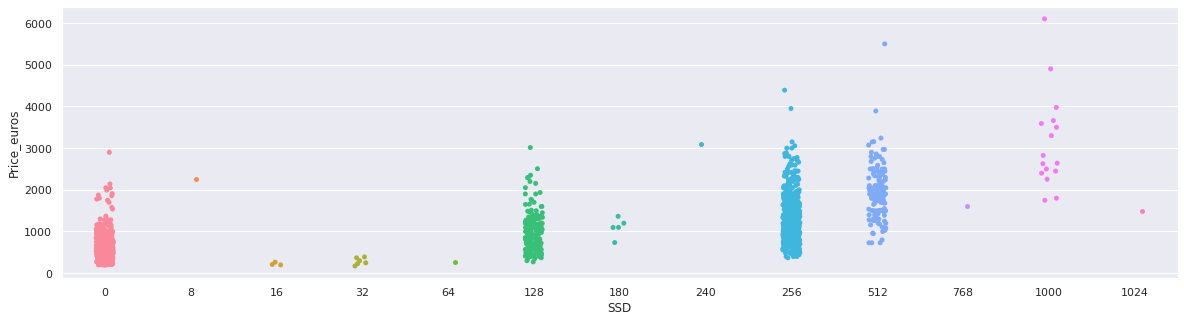

In [98]:
sns.stripplot(x=df["SSD"], y=y)

In [99]:
df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'OpSys', 'Weight', 'Price_euros', 'Convertible',
       'Retina Display', 'Touchscreen', 'IPS Panel', 'Quad HD+', 'Ultra HD',
       'CPU brand', 'Cpu speed', 'free OpSys', 'GPU_provider', 'SSD', 'HDD',
       'Flash Storage', 'Hybrid', 'Pixels Per Inch'],
      dtype='object')

<AxesSubplot:xlabel='Retina Display', ylabel='Price_euros'>

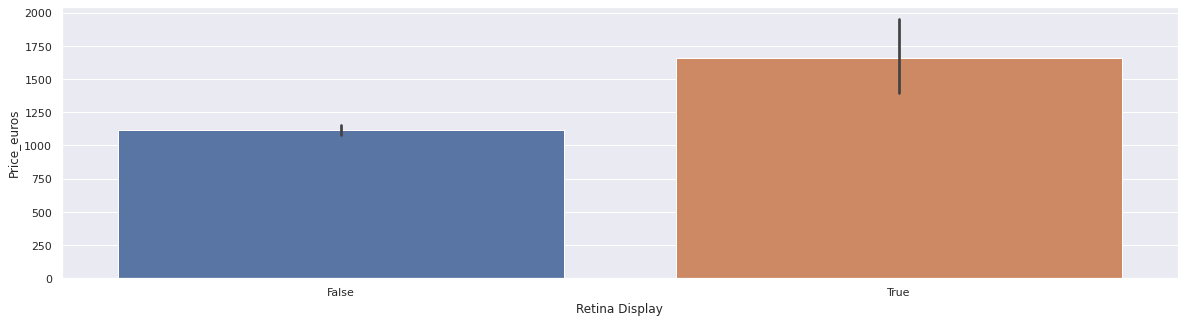

In [100]:
sns.barplot(x=df["Retina Display"], y=df["Price_euros"])

<AxesSubplot:xlabel='Cpu speed', ylabel='Price_euros'>

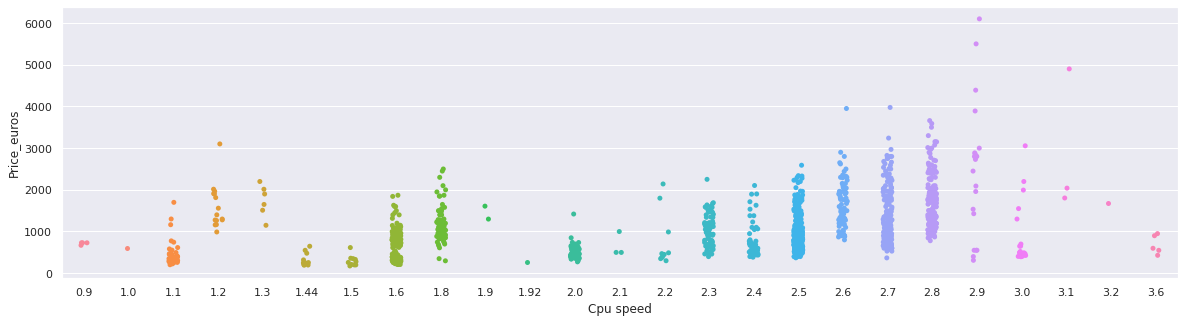

In [101]:
sns.stripplot(x=df["Cpu speed"], y=df["Price_euros"])

<AxesSubplot:xlabel='Company', ylabel='Price_euros'>

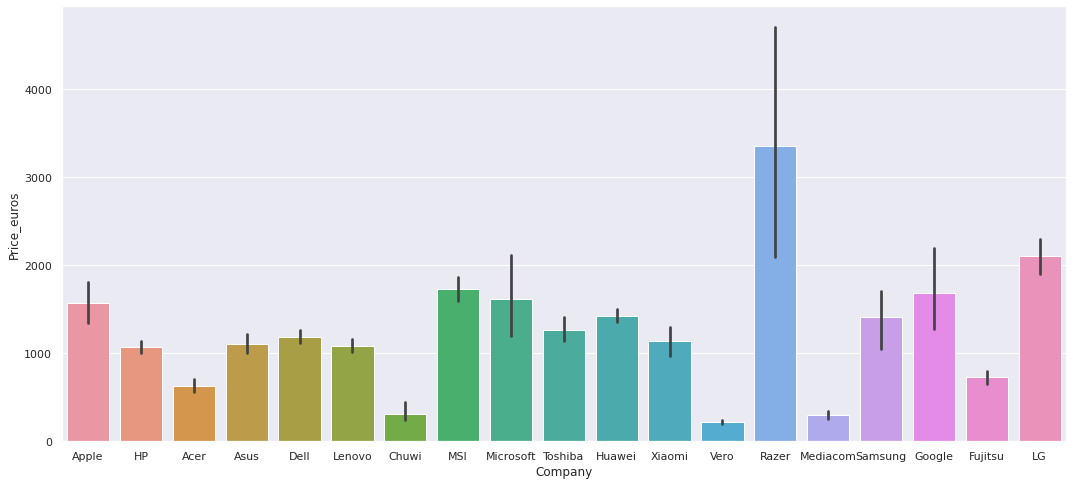

In [102]:
sns.set(rc = {'figure.figsize':(18,8)})
sns.barplot(x=df["Company"], y=df["Price_euros"])

/home/sayat/.local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sayat/.local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sayat/.local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sayat/.local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 66.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Inches', ylabel='Price_euros'>

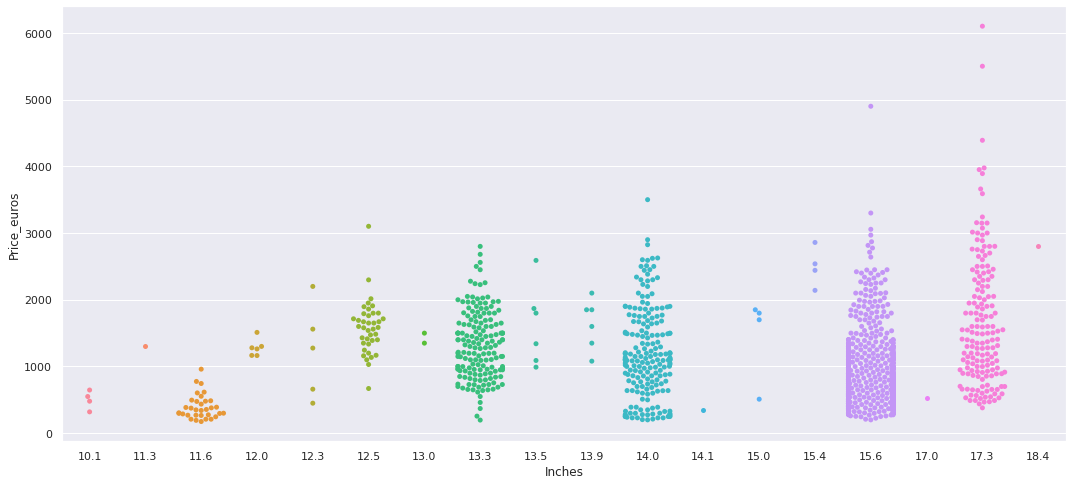

In [103]:
sns.swarmplot(x=df["Inches"], y=df["Price_euros"])

<AxesSubplot:xlabel='GPU_provider', ylabel='Price_euros'>

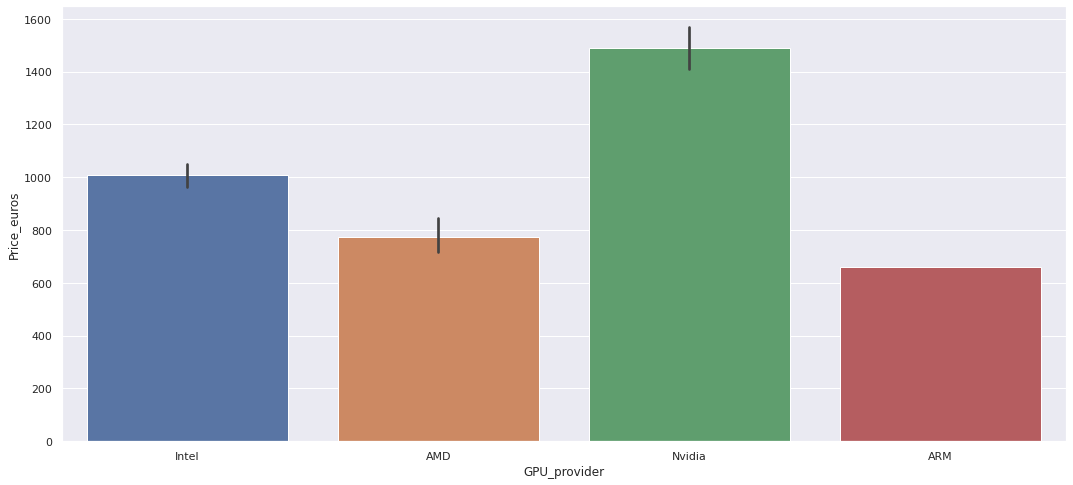

In [104]:
sns.barplot(x=df["GPU_provider"], y=df["Price_euros"])

<AxesSubplot:xlabel='free OpSys', ylabel='Price_euros'>

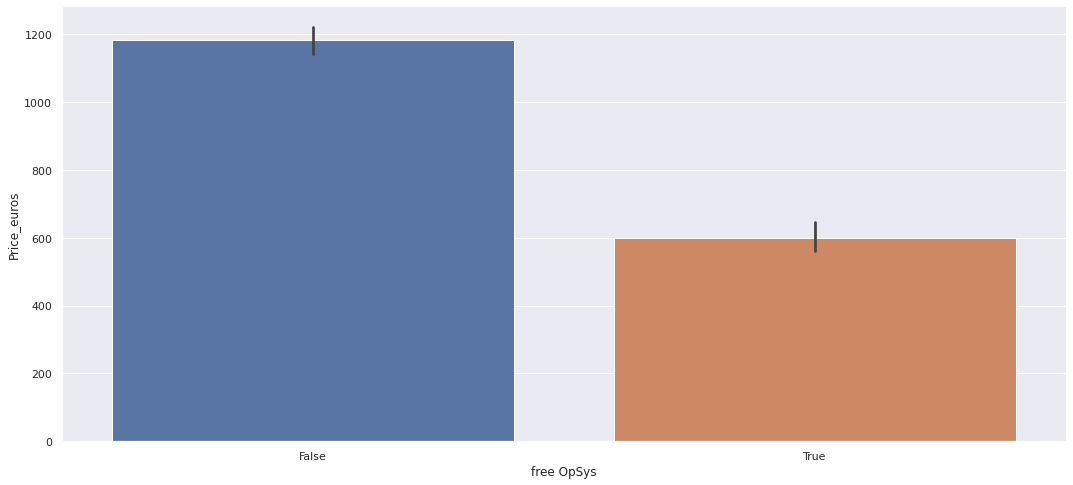

In [105]:
sns.barplot(x=df["free OpSys"], y=df["Price_euros"])

<AxesSubplot:xlabel='Ram', ylabel='Price_euros'>

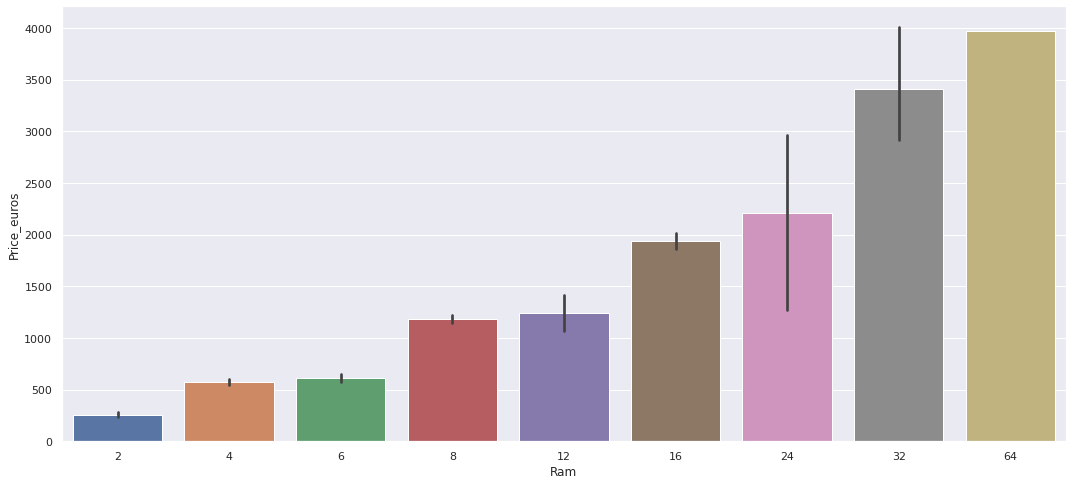

In [106]:
sns.barplot(x=df["Ram"], y=df["Price_euros"], order=sorted(df["Ram"].unique()))

<AxesSubplot:xlabel='ScreenResolution', ylabel='Price_euros'>

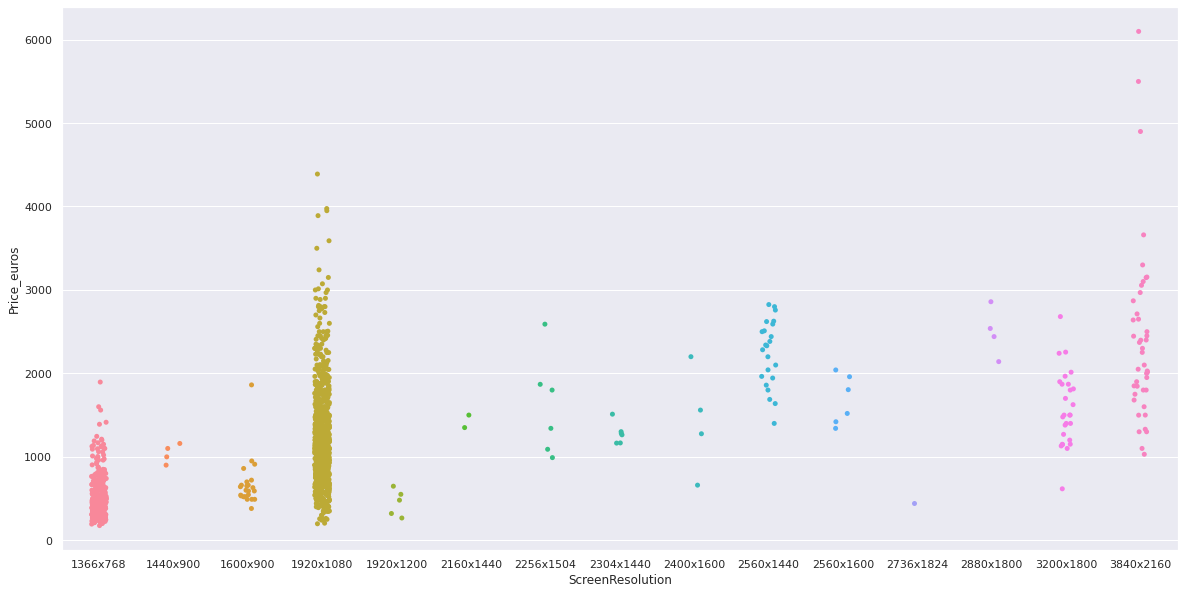

In [107]:
sns.set(rc = {'figure.figsize':(20,10)})

sns.stripplot(x=df["ScreenResolution"], y=df["Price_euros"], order=sorted(df["ScreenResolution"].unique()))

<AxesSubplot:xlabel='Pixels Per Inch', ylabel='Price_euros'>

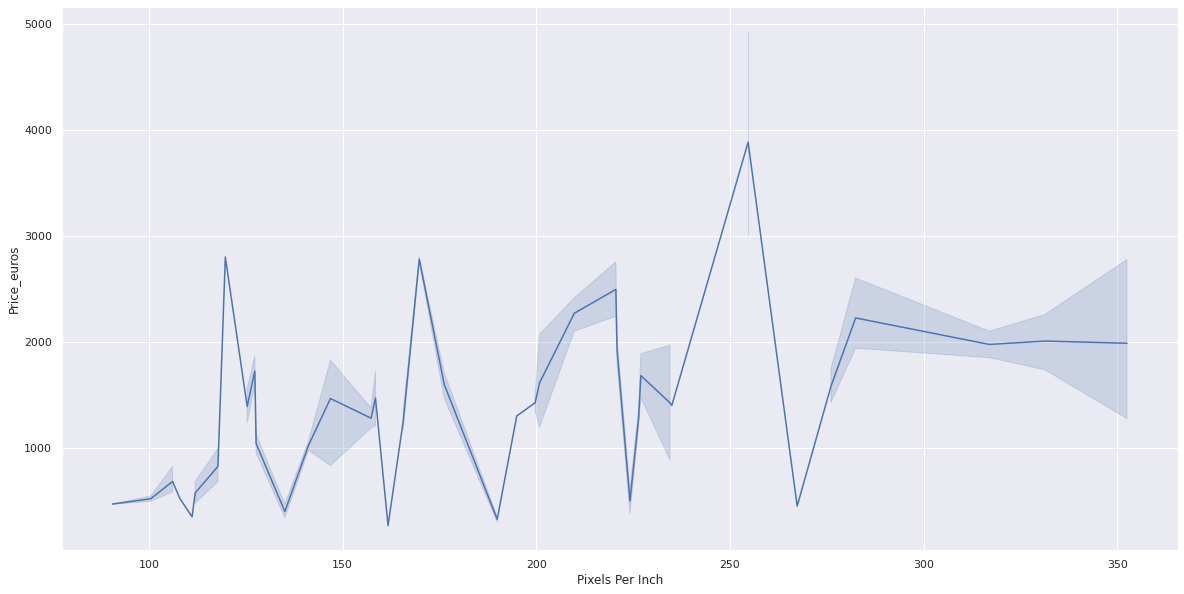

In [108]:
sns.set(rc = {'figure.figsize':(20,10)})

sns.lineplot(x=df["Pixels Per Inch"], y=df["Price_euros"])#, order=sorted(df["Pixels Per Inch"].unique()))


In [109]:
df.drop(columns=['Memory'], inplace=True)

In [110]:
y = df['Price_euros']

In [111]:
boolean_features = ['Convertible', 'Retina Display', 'Touchscreen', 'IPS Panel', 'Quad HD+', 'Ultra HD', 'free OpSys']

for feature in boolean_features:
    df[feature] = df[feature].astype(int)

In [112]:
df['Ram'] = df['Ram'].astype(float)
df['Weight'] = df['Weight'].astype(float)

In [113]:
y = df['Price_euros']

In [114]:
df.drop(columns=['Price_euros'], inplace=True)

In [115]:
non_boolean_ordinal_features = ['ScreenResolution', 'CPU brand']

In [116]:
nominal_features = ['Company', 'TypeName', 'GPU_provider', 'Cpu', 'OpSys', 'Product']

In [117]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [118]:
column_transform = make_column_transformer(
    (OrdinalEncoder(), non_boolean_ordinal_features),
    (OneHotEncoder(), nominal_features),
    remainder='passthrough'
    
)


res = column_transform.fit_transform(df)

scaler = MaxAbsScaler()
tr = scaler.fit_transform(res)


In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.svm import SVC

In [120]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [ ]:
for i in [500, 1000, 2000]:
    for j in [0, 5, 10, 15, 20]:
        model = GradientBoostingRegressor(n_estimators=i, random_state=j)
        score = cross_val_score(model, tr, y, cv=kf, scoring='neg_mean_absolute_error')
        print(score.mean(), model.__class__.__name__, i, j)

-168.91156157847988 GradientBoostingRegressor 500 0
-165.64611367453318 GradientBoostingRegressor 500 5
-166.35558313862367 GradientBoostingRegressor 500 10
-164.52929205408506 GradientBoostingRegressor 500 15
-160.99299557292812 GradientBoostingRegressor 500 20
-160.03666097514972 GradientBoostingRegressor 1000 0
-155.45611430494074 GradientBoostingRegressor 1000 5
-161.2115169752637 GradientBoostingRegressor 1000 10
-157.73927104755793 GradientBoostingRegressor 1000 15


In [ ]:
kf = KFold(shuffle=True, n_splits=5)

models = [RandomForestRegressor(i, random_state=10) for i in [5,10,20,50,100, 200,500]]
models.extend(XGBRegressor(n_estimators=i, random_state=10) for i in [5,10,20,50,100,200,500])
models.extend(GradientBoostingRegressor(n_estimators=i, random_state=j) for i in [5,10,20,50,100,200,500] for j in [5, 10, 15, 20])

    
models.extend([LinearRegression(), ExtraTreesRegressor(), LGBMRegressor() ])
for model in models:
    score = cross_val_score(model, tr, y, cv=kf, scoring='r2')
    print(score.mean(), model.__class__.__name__)

In [ ]:
kf = KFold(shuffle=True, n_splits=5)

models = [RandomForestRegressor(i, random_state=10) for i in [5,10,20,50,100, 200,500]]
models.extend(XGBRegressor(n_estimators=i,booster='dart') for i in [5,10,20,50,100,200,500])
models.extend(GradientBoostingRegressor(n_estimators=i, random_state=10) for i in [5,10,20,50,100,200,500])

    
models.extend([LinearRegression(), ExtraTreesRegressor(), LGBMRegressor() ])
for model in models:
    score = cross_val_score(model, tr, y, cv=kf, scoring='r2')
    print(score.mean(), model.__class__.__name__)